# League of Legends Data Analysis Tutorial
    by Gerald Liu and On Choi
     - CMSC 320 Fall 2019

<img src="https://i.pinimg.com/originals/4c/0b/51/4c0b5190cf49d2d3e16d8ab56c632b44.jpg" width="500" height="200"/>
<img src="https://media.comicbook.com/2019/04/riot-games-logo-1167492-1280x0.jpeg"  width="200" height="200"/>


## 1. Introduction

League of Legends (LoL) is a MOBA (Multiplayer Online Battle Arena) published by Riot Games in 2009 and is the [most popular online PC game](https://newzoo.com/insights/rankings/top-20-core-pc-games/) as of November 2019. The competitive scene or e-sports has been popular among players and the most recent international tornament had an estimated 99.6 million viewers and had a $2.5 million prize pool for over 100 teams accross 13 regions around the world [(source)](https://www.businessinsider.com/league-of-legends-world-championship-winner-funplus-phoenix-photos-2019-11). There is an estimated >100 million matches of league played per day with 8 million concurrent players at any given time as of 2017 and that number as only gone up. As a result, the LoL has generated a plethora of data over the years and much can be learned from any perspective and purpose. 


In our tutorial, we will looking at match and player data for the North American Server for the latest season as of December 2019. We will crawl the league API to gather and tidy up useful data to see if we can find any patterns. This will involve an in-depth exploratory data analysis (EDA) to find any useful patterns such as predicting win rate and finding most important factor in winning a game. We hope that this tutorial can provide insight in how the Riot API works and to encourage new and experienced players to see how interconnected the field of data science and video games can really be. 


 __1.1 [How do you play League of Legends?](https://www.youtube.com/watch?v=BGtROJeMPeE) How does one win?__
 
<img src="https://www.researchgate.net/profile/Patrick_Shih/publication/319839481/figure/fig1/AS:539281729228800@1505586191613/A-Map-of-the-League-of-Legends-game-play-in-the-classic-mode.png" width="600" height="150"/>

                                                                                            -Map of League of Legends


 - Traditional Competitive League of Legends (LoL) is played by 10 players with 2 sides (Blue and Red side) having 5 players each.
 - The objective is to destroy the opposing team's Nexus or base.
 - Each player chooses a "champion" (playable character) before the game starts. This champion is chosen in  mind to work with your team and your own strengths. At the time of this tutorial, there are [146 playable champions](https://na.leagueoflegends.com/en/game-info/champions/). 
 - Each "champion" has a unique set of skills that can range from dealing tons of damage, healing, or applying "crowd control" buffs/debuffs (CC) such as stuns, binds, and freezes. 
 
 
 - Furthermore, each champion fall under a list of categories or classes. Some champions are exclusivly ranged marksman fighters, some are melee based and prefer to fight on the front lines, and some are magic based mages that cast spells as their primary way of damage. 
 - The champion classes are listed [here](https://na.leagueoflegends.com/en/news/game-updates/gameplay/taking-another-look-subclasses) and include Tanks, Fighters, Slayers, Mages, Controllers, and Marksmen. 
 
 - To defeat the enemy base or Nexus, you must destroy at every turret in at least 1 lane (Top, Mid, Bottom). Then, you will need to destroy at least 1 inhibitor and both the Nexus turrets to finally break the enemy nexus open. 
 - This process can take 15 minutes up to over an hour depending on how back and forth the game is going.
 

 - At 1 minute 5 seconds, waves of "minions" will spawn every 30 seconds for each team and for each lane. These minions are controlled by the game's AI and have only a basic attacking skill (melee, caster, seige) that help their team's players take towers and progress the game. Once an inhibitor is destroyed for a certain lane, "super" minions start to spawn that make them very strong and help push lanes even more. 
 
 
 - Players will be given gold as the game progresses (passive income) and also awarded gold for killing enemy "minions" (also called creep), enemy champions (players), or capturing certain game objectives (towers, baron, first blood, ect). 
 - This gold can be used to buy items in the shop to obtain powerful weapons and bonuses that can make your champion extremely strong.  
 
 - Players also get experience and level up from being in the area of enemy minion, player, or objective deaths. Each level (max 18) gives you more base stats and a skill point which can be used to level up your skills (usually max level 5, max level 3 for ultimate). These skill upgrades are cruicial to winning the game as they provide more damage, longer CC, more healing, ect. 
 
 - Most champions (some are unique) have an ultimate ability (unlocked at level 6) that have longer cooldowns but can significantly sway the course of a match. 
 
 
 
We've only listed the basics and there's so much more to learn about the game, its community, and the compeitive scene. You can learn more at https://na.leagueoflegends.com/en/.

## 2. Required Libraries/Resources

 - All libraries and code will be imported/written with python 3 in mind. If you have python 2, use the future library or upgrade :D
 - To scrape League of Legends data, we need requets, beautifulsoup4, and json
 - Pandas and Numpy will be used to transform and tidy our dataset
 - matplotlib and seaborn for data visualization
 - sklearn for predictions and machine learning
 - urllib for converting characters in string into escaped characters (for hitting the API)
 - time to sleep for rate limit
 - random to randomly crawl riot api
 
 
 - We need an API key to access the Riot API. We will load it from a hidden file called 'api_key.json'. Generate yours at https://developer.riotgames.com/. 

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
import urllib
import time
import random
import warnings
warnings.filterwarnings('ignore')

# API Key obtained from Riot Developer Portal (unique for account expires every 16 hours)
# However, you can apply for an permanent API key at https://developer.riotgames.com/app-type 
API_KEY = 'XXXXX-XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXX'
# We have our API key loaded from a json file (can also be stored as an evironment variable if you would like)
with open('api_key.json') as f:
    API_KEY = json.load(f)['API_KEY']

# These are our parameters we will be working with for match data
PARAMS = ['gameId', 'summonerId', 'seasonId', 'gameVersion', 'gameMode', 'gameType', 'queueId', 'teamId', 'gameDuration',\
          'win', 'participantId', 'role', 'tier', 'rank','kills', 'deaths', 'assists','championId', 'minionsKilled',\
          'champLevel', 'wardsPlaced', 'goldEarned', 'goldSpent', 'visionScore', 'totalDamageDealt', 'largestMultiKill',\
          'teamFirstBlood', 'teamFirstTowerKill', 'teamFirstInhibitor', 'teamFirstBaron', 'teamFirstDragon',\
          'teamFirstRiftHerald', 'towerKills', 'inhibitorKills', 'baronKills', 'dragonKills', 'riftHeraldKills']

# Set random seed
random.seed(1)

# 3. Data Collection (API Crawling)

To gather match data, Riot provides an [API](https://developer.riotgames.com/apis) that has data for matches, summoners (players), champions (playable characters), ect.

 
 
 ## Using Riot's API
 
 - Riot has a [developer portal](https://developer.riotgames.com/) which you will need a Riot [account](https://developer.riotgames.com/login). 
 - You will need an API Key and generate it daily or [apply for a product API key](https://developer.riotgames.com/app-type) which will persist.
 - Documentation can be found at https://developer.riotgames.com/apis
 - Riot has rate limits of 20 requests/second and 100 requests/2 min. Data generation will take a while to generate enough data to learn on. Therefore, we will export data into a file to pull from while generating data as often as we can. 
 - Example for calling summoner (player) information for current API version (v4):
     - https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/SUMMONER_NAME?api_key= + API_KEY
     
     
### "Random" Game Data
 
 - Riot only provides game data from a given gameID which cannot be randomly gotten. Therefore, we need to start from a seeded playerID and crawl through that players' teammates and opponents games to generate enough data to preform data analysis.
 
 
 - Our set seed will be on one of our summoner IDs "50g Tibbers" on the North American server. 
 
 Scrapping Methods:
    
 
    - get_random_matches(num_matches, seed_summoner, key, region, season, sleep_delay)
        Main scrapping function
        
        Will output matchData.csv with match data and log.txt for any troubleshooting
        - Will return pandas DataFrame with data on a given # of matches (int: num_matches=100)
        - Needs a seed summoner to start API Crawling (string: seed_summoner)
        - Needs your riot API key to pull requests with (string: key=API_KEY)
        - Need a valid league of legends region (string: region='na1')
        - Needs a valid season # to pull correct matches from (int: season=13)
        - Between matches, function will sleep to account for API latency (float: sleep_delay=0.2)
    
    - tidy_game_data(match, region, key)
        - Given a league of legends match, transform into a pandas DataFrame and return
        - 10 rows = 10 players and their stats (see PARAMS global for column names)
    
    - get_match_history(region, accountId, key)
        - Given an accountId, return match history of account
        
    - get_match_info(region, matchId, key)
        - Given matchId, return match information from API
        
    - transform_match(match, visited_players, region, key, seed=None)
        - From a match, select the next accountId to continue API crawl
    
    - get_most_recent_valid(match_history, visited_matches, correct_queues, season, visited_players)
        - Recursively find the most recent valid match from match history
        - If invalid history found, will continue to crawl on a randomly seen summoner

In [2]:
def tidy_game_data(match, region, key):
    players = match['participants']
    player_rows = []
    df = pd.DataFrame(columns=PARAMS)
    for n in range(len(players)):
        player = players[n]
        summonerId = match['participantIdentities'][n]['player']['summonerId']
        stats = player['stats']
        teamId = player['teamId']
        wardsPlaced = 0
        status_200 = False
        
        # Get player's league rank
        while not status_200:
            league = requests.get("https://{}.api.riotgames.com/lol/league/v4/entries/by-summoner/{}?api_key={}".format(region, summonerId, key))
            time.sleep(1.2)
            if league.status_code == 200:
                status_200 = True
                league = league.json()
            else:
                print("Error {} restarting query on {}".format(league.status_code, summonerId))
                
        tier = 'UNRANKED'
        rank = 'N/A'
        if league:
            tier = league[0]['tier']
            rank = league[0]['rank']
        log = open(r"log.txt", "a+")
        log.write("Player {}, summonerId: {}, Tier: {}, Rank: {}\n".format(n+1, summonerId, tier, rank))
        log.close()
        # Sometimes no wards are placed
        if 'wardsPlaced' in stats:
            wardsPlaced = stats['wardsPlaced']
        row = {
            'gameId': match['gameId'],
            'summonerId': summonerId,
            'seasonId': match['seasonId'],
            'gameVersion': match['gameVersion'],
            'gameMode': match['gameMode'],
            'gameType': match['gameType'],
            'queueId': match['queueId'],
            'teamId': teamId,
            'gameDuration': match['gameDuration'],
            'win': stats['win'],
            'participantId': player['participantId'],
            'role': player['timeline']['lane'],
            'tier': tier,
            'rank': rank,
            'kills': stats['kills'],
            'deaths': stats['deaths'],
            'assists': stats['assists'],
            'championId': player['championId'],
            'minionsKilled': stats['totalMinionsKilled'],
            'champLevel': stats['champLevel'],
            'wardsPlaced': wardsPlaced,
            'goldEarned': stats['goldEarned'],
            'goldSpent': stats['goldSpent'],
            'visionScore': stats['visionScore'],
            'totalDamageDealt': stats['totalDamageDealt'],
            'largestMultiKill': stats['largestMultiKill'],
        }
        for team in match['teams']:
            if team['teamId'] == teamId:                    
                row['teamFirstBlood'] = team['firstBlood']
                row['teamFirstTowerKill'] = team['firstTower']
                row['teamFirstInhibitor'] = team['firstInhibitor']
                row['teamFirstBaron'] = team['firstBaron']
                row['teamFirstDragon'] = team['firstDragon']
                row['teamFirstRiftHerald'] = team['firstRiftHerald']
                row['towerKills'] = team['towerKills']
                row['inhibitorKills'] = team['inhibitorKills']
                row['baronKills'] = team['baronKills']
                row['dragonKills'] = team['dragonKills']
                row['riftHeraldKills'] = team['riftHeraldKills']
                # bans added here
        df = df.append(row, ignore_index=True)
    return df

In [3]:
def get_match_history(region, accountId, key):
    log = open(r"log.txt", "a+")
    log.write("Attempting to get match history for accountId: {}\n".format(accountId))
    log.close()
    while True:
        # https://developer.riotgames.com/apis#match-v4/GET_getMatchlist
        match_history = requests.get("https://{}.api.riotgames.com/lol/match/v4/matchlists/by-account/{}?api_key={}".format(region, accountId, key))
        # Sleep to account for rate limit. 100 requests per 2 minutes
        time.sleep(1.2)
        if match_history.status_code == 200:
            return match_history.json()

def get_match_info(region, matchId, key):
    # https://developer.riotgames.com/apis#match-v4/GET_getMatch
    while True:
        match = requests.get("https://{}.api.riotgames.com/lol/match/v4/matches/{}?api_key={}".format(region, matchId, key))
        # Sleep to account for rate limit. 100 requests per 2 minutes
        time.sleep(1.2)
        if match.status_code == 200:
            return match.json()

def transform_match(match, visited_players, region, key, seed=None):
    # Players should have length 10 (5 players vs. 5 players)
    players = match['participantIdentities']
    player_counter = 0
    # Grab a random player from match (ally or enemy team)
    random_order = list(range(len(players)))
    if seed:
        random.seed(seed)
    # Random order is seeded above (to replicate results)
    random.shuffle(random_order)
    for n in random_order:
        chosen_one = players[n]['player']['currentAccountId']
        # Ensure that player has not been seen before
        if chosen_one not in visited_players:
            visited_players.add(chosen_one)
            return tidy_game_data(match, region, key), chosen_one, visited_players
        player_counter += 1
        # If all players have been seen...
        if player_counter == len(players):
            raise Exception("All players seen (unlikely) Should choose a new summoner to crawl... but implementation later")
        
def get_most_recent_valid(match_history, visited_matches, correct_queues, season, visited_players):
    for match in match_history['matches']:
        if match['season'] == season and match['gameId'] not in visited_matches and match['queue'] in correct_queues:
            visited_matches.add(match['gameId'])
            return match, visited_matches\
    # If seed summoner has no valid matches in history
    if len(visited_matches) == 0:
        raise Exception("Seed summoner has no valid 5v5 PVP matches in their history.")
    # If invalid match history
    random_summoner = random.choice(tuple(visited_players))
    log = open(r"log.txt", "a+")
    log.write("Match history is bad. Chosing new random summoner {} to keep crawling on.\n".format(random_summoner))
    log.close()
    # Recurse until valid match is found
    match_history = get_match_history(region, random_summoner, key)['matches']
    get_most_recent_valid(match_history, visited_matches, correct_queues, season, visited_players)

In [4]:
# Grab random PVP matches based on seed_summoner exlusive to region/season but any rank and any player level. 
def get_random_matches(num_matches=100, seed_summoner="50g Tibbers", key=API_KEY, region="na1", season=13, sleep_delay=0.2):
    start_time = time.time()
    # Clear log file
    open(r"log.txt", 'w').close()
    # Estimated Time based on rate limit
    seconds = (num_matches * 1.2) * 11 + num_matches * sleep_delay
    print("Getting {} matches. This will take minimum {} seconds to complete. \n".format(num_matches, seconds))
    
    # Get seed summoner accountId
    seed_request = requests.get("https://{}.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}".format(region, seed_summoner, API_KEY))
    # Sleep to account for rate limit. 100 requests per 2 minutes
    time.sleep(1.2)
    # If status code 404, raise exception
    if seed_request.status_code == 404:
        raise Exception("Error Code 404. Invalid seed_summoner, region, or API key (ensure that it has not expired).")
    seed_json = seed_request.json()
    accountId = seed_json['accountId']
    summonerIds = [] #seed_json['id']
    print("Seed Summoner = {}. accountId = {}".format(seed_summoner, accountId))
    
    # Keep visited set to ensure no duplicates
    visited_players = set()
    visited_matches = set()
    
    # Add seed_summoner accountId to visited (we start here and crawl)
    visited_players.add(accountId)
    
    # Only select 5v5 PVP games (blind = 430, draft = 400, ranked = 420)
    # All queueId constants found here: http://static.developer.riotgames.com/docs/lol/queues.json
    correct_queues = set([430, 400, 420])
    
    # Match DataFrame that holds all match data and will be returned
    matches = pd.DataFrame(columns=PARAMS)

    for m in range(num_matches):

        # Grab account's match history from API
        match_history = get_match_history(region, accountId, key)
        
        # Get most recent valid game from season parameter. Then grab gameId to get match info.
        most_recent, visited_matches = get_most_recent_valid(match_history, visited_matches, correct_queues, season, visited_players)
        gameId = most_recent['gameId']

        # Grab match info from API
        match = get_match_info(region, gameId, key)
        log = open(r"log.txt", "a+")
        log.write("Found match #{}: {} for {}\n".format(m+1, gameId, accountId))
        log.close()
        # Transform match format into pandas DataFrame
        rows, accountId, visited_players = transform_match(match, visited_players, region, key)
        # Add to matches DataFrame
        matches = matches.append(rows)
        
        # Sleep for good measure (can be configured based on API latency)
        # Check here for riot api status: https://developer.riotgames.com/api-status/
        time.sleep(sleep_delay)
        
        # Now, we should have another accountId to work with
        # Continue loop until we have num_matches
        
    
    # Display runtime and return matches and summonerId list
    runtime = time.time() - start_time
    log = open(r"log.txt", "a+")
    log.write("Found {} matches in {} seconds\n".format(len(matches), runtime))
    print("Found {} matches in {} seconds".format(len(matches), runtime))
    log.close()
    return matches

In [5]:
matches = get_random_matches(num_matches=10)
matches.head()

Getting 10 matches. This will take minimum 134.0 seconds to complete. 

Seed Summoner = 50g Tibbers. accountId = e9Po7IYch-H6xHFLKmwAAoVDSXHRRIvdpbWQv-6mtLM7njA
Found 100 matches in 192.25054168701172 seconds


,gameId,summonerId,seasonId,gameVersion,gameMode,gameType,queueId,teamId,gameDuration,win,...,teamFirstTowerKill,teamFirstInhibitor,teamFirstBaron,teamFirstDragon,teamFirstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,riftHeraldKills
0,3230641357,u3hgu6OSYPZyTfZ6QsRLYeVZQo7ZIo2-u-EbRknJVsrlZec,13,9.23.299.3089,CLASSIC,MATCHED_GAME,430,100,2434,False,...,False,False,True,True,False,4,0,1,2,0
1,3230641357,_wPeIXZOp9llE_4CHAY60YJAGAXuCcE--844EgI0OwM2VCU,13,9.23.299.3089,CLASSIC,MATCHED_GAME,430,100,2434,False,...,False,False,True,True,False,4,0,1,2,0
2,3230641357,pyylEUtmsIdHA6XK6DVa7s78F4nM5KPSU6nLHOxK3nQqu3E,13,9.23.299.3089,CLASSIC,MATCHED_GAME,430,100,2434,False,...,False,False,True,True,False,4,0,1,2,0
3,3230641357,fTYHg_J0f59BCKPMIaxrRTskHj12rF3dqrjVr9drFuyn_Ik,13,9.23.299.3089,CLASSIC,MATCHED_GAME,430,100,2434,False,...,False,False,True,True,False,4,0,1,2,0
4,3230641357,t_24_n0xdm8jANEvts-kSuKccs2L6uNwM1e5exqGfp_5JrM,13,9.23.299.3089,CLASSIC,MATCHED_GAME,430,100,2434,False,...,False,False,True,True,False,4,0,1,2,0


In [6]:
matches.columns

Index(['gameId', 'summonerId', 'seasonId', 'gameVersion', 'gameMode',
       'gameType', 'queueId', 'teamId', 'gameDuration', 'win', 'participantId',
       'role', 'tier', 'rank', 'kills', 'deaths', 'assists', 'championId',
       'minionsKilled', 'champLevel', 'wardsPlaced', 'goldEarned', 'goldSpent',
       'visionScore', 'totalDamageDealt', 'largestMultiKill', 'teamFirstBlood',
       'teamFirstTowerKill', 'teamFirstInhibitor', 'teamFirstBaron',
       'teamFirstDragon', 'teamFirstRiftHerald', 'towerKills',
       'inhibitorKills', 'baronKills', 'dragonKills', 'riftHeraldKills'],
      dtype='object')

In [7]:
matches[['gameId', 'teamId', 'win', 'participantId', 'championId', 'tier', 'rank', 'kills', 'deaths', 'assists', 'minionsKilled', 'goldEarned', 'teamFirstBlood']].head()

,gameId,teamId,win,participantId,championId,tier,rank,kills,deaths,assists,minionsKilled,goldEarned,teamFirstBlood
0,3230641357,100,False,1,104,GOLD,III,17,11,9,218,19466,True
1,3230641357,100,False,2,64,SILVER,II,6,9,7,28,13090,True
2,3230641357,100,False,3,17,SILVER,II,3,10,11,34,10160,True
3,3230641357,100,False,4,235,SILVER,IV,5,9,14,154,14722,True
4,3230641357,100,False,5,13,GOLD,III,5,8,4,209,14312,True


In [8]:
matches.to_csv("matchData.csv", index=False)

# 4. Exploratory Data Analysis

After getting the data from the API and cleaning it, we can analyze the data!

In [208]:
matches = pd.read_csv(r'matchData.csv')

### Rank Distribution

Since we seeded off of a Platinum player, the rank of our player base is going to be based around this level. We can analyze the rank distribution and compare it to [op.gg](https://na.op.gg/statistics/tier/) (a website that pulls millions of players' data and make analysis) to see how relevant our sample is. Then we can make adjustment to our prediction while keeping this bias in mind.

<img src="https://am-a.akamaihd.net/image?f=https://news-a.akamaihd.net/public/images/articles/2019/january/ranked2019/Lineup.jpg&resize=640:" />

                                                                                            -Ranking Tiers

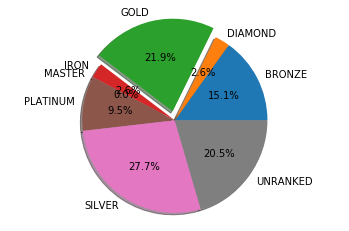

In [209]:
rankgroup = matches.groupby('tier')
count = [rankgroup.get_group(r)['tier'].count() for r in rankgroup.groups]
rank = [r for r in rankgroup.groups]
explode = [0, 0, 0.1, 0, 0, 0, 0, 0]

fig1, ax1 = plt.subplots()
ax1.pie(count, explode=explode, labels=rank, autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')
plt.show()

Based on [op.gg](https://na.op.gg/statistics/tier/)'s statistic, below are their player rank distribution
-    _Challenger_	(0.02%)
-    _Grandmaster_	(0.04%)
-    _Master_	(0.09%)
-    _Diamond_	(3.48%)
-    _Platinum_	(14.5%)
-    _Gold_	(33.13%)
-    _Silver_	(32%)
-    _Bronze_	(14.84%)
-    _Iron_	(1.91%)

Our pool seems to have more silver rank compared to gold rank as opposed to op.gg's. However, out of the 5000 match data, we only have 2 sample data for master rank and nothing above that. We will have to deal with master rank or above separately.

### Rank In Terms of Vision Score

__What is warding? What is vision score?__ <br>
- As seen in the introduction, players play on a map labelled with different locations like top, bottom, middle, and jungle. In the jungle, there is a fog of war that covers more than half the map. Therefore it is very important to have vision at some parts of the map to gain knowledge on opponents' next movement.
- There is an item in the game that you can purchase called "ward". There are two types: the green ward and the pink ward. A green ward grants vision of an area within a small radius for up to 90 seconds. When it is placed, it gains invisibility after a couple seconds. An opponent can detect wards in an area using a sweeper item. A pink ward grants vision of an area within a small radius forever as long as the user of the ward has not placed another one elsewhere or the ward itself has not been destroyed. The pink ward does not go invisible and takes four hits to get destroyed.
- <ins>Warding</ins> is the act of purchasing and placing wards on the map. This is a very important aspect of the game as it allows the entire team to gain information about the other team's whereabout. The placement of the wards is important because it affects how much information you know.
- <ins>Vision score</ins> is a post-game statistic that Riot Game added to the post-game match analysis in 2017. It tells you how much vision a player has influenced the game. This is calculated mostly based on the lifetime of wards a player provided and the lifetime of wards a player denied in the game. The more complex and in-depth lifetime calculation can be found [here](https://leagueoflegends.fandom.com/wiki/Vision_score).

<img src="http://qtoptens.com/wp-content/uploads/2017/09/dragontrainer.jpg" width="500" height="200"/>

                                                - Invisible green ward vs. pink ward

In [210]:
# Define the order of ranks
rank_order = ['UNRANKED', 'IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND', 'MASTER']
rank_dict = {r: None for r in rank_order} 
for r in rankgroup.groups:
    rank_dict[r] = rankgroup.get_group(r)['visionScore'].mean()

rankgroup.describe()['visionScore']

,count,mean,std,min,25%,50%,75%,max
tier,,,,,,,,
BRONZE,1511.0,17.795500,13.870207,0.0,9.00,15.0,22.00,157.0
DIAMOND,262.0,20.805344,17.074445,0.0,10.00,17.0,26.00,126.0
GOLD,2193.0,20.364797,14.675569,0.0,11.00,17.0,25.00,108.0
IRON,262.0,20.225191,13.853048,0.0,11.00,17.0,26.00,88.0
MASTER,2.0,13.500000,19.091883,0.0,6.75,13.5,20.25,27.0
PLATINUM,952.0,21.268908,15.437100,0.0,11.00,17.0,26.00,124.0
SILVER,2771.0,18.812342,13.771241,0.0,10.00,16.0,24.00,104.0
UNRANKED,2047.0,15.345383,13.271450,0.0,7.00,12.0,20.00,107.0


This table shows the mean of vision score among each rank group, as well as its percentile and other statistics.

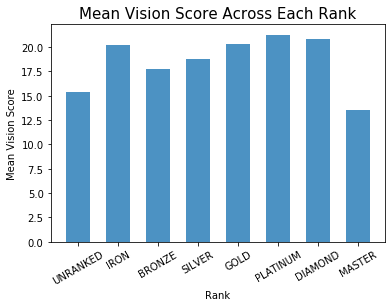

In [211]:
plt.bar(list(rank_dict.keys()), list(rank_dict.values()), alpha=0.8, width=0.6)
plt.xlabel('Rank', fontsize=10)
plt.ylabel('Mean Vision Score', fontsize=10)
plt.title('Mean Vision Score Across Each Rank', fontsize=15)
plt.xticks(rank_order, fontsize=10, rotation=30)
plt.show()

For now, we can ignore the value for master rank since we simply do not have enough data (2 out of 10000 in the sample) about it to make prediction.

In this bar graph, the rank are ordered from the lowest to the highest rank. It appears that the vision score tends to be higher if the player is higher rank. This makes sense since warding is a very important aspect of the game and is a part of the game strategies. If the player is more knowledgeable about the game, then they are more likely to know the importance of warding.

#### How about gold?
Gold is the in-match currency that allows you to buy items in a single match. You can earn gold through killing opponents or assisting allies with kills, and killing minions in lane and monsters in the jungle.

In [212]:
gold_dict = {r: None for r in rank_order} 
for r in rankgroup.groups:
    gold_dict[r] = rankgroup.get_group(r)['goldEarned'].mean()
gold_dict

{'UNRANKED': 9432.154372252076,
 'IRON': 10084.729007633588,
 'BRONZE': 9872.716082064857,
 'SILVER': 10123.006134969326,
 'GOLD': 10512.409940720474,
 'PLATINUM': 10324.807773109243,
 'DIAMOND': 10300.267175572519,
 'MASTER': 7893.0}

In [213]:
rankgroup.describe()['goldEarned']

,count,mean,std,min,25%,50%,75%,max
tier,,,,,,,,
BRONZE,1511.0,9872.716082,3897.957263,707.0,7165.00,9495.0,12236.00,29857.0
DIAMOND,262.0,10300.267176,4487.271199,683.0,7398.50,10053.0,13509.00,23893.0
GOLD,2193.0,10512.409941,3921.653617,673.0,7755.00,10103.0,13002.00,27886.0
IRON,262.0,10084.729008,3805.822339,732.0,7141.75,9526.5,12236.00,22111.0
MASTER,2.0,7893.000000,9958.891906,851.0,4372.00,7893.0,11414.00,14935.0
PLATINUM,952.0,10324.807773,3827.481810,690.0,7624.25,9953.5,12592.25,25712.0
SILVER,2771.0,10123.006135,3914.604528,675.0,7386.00,9775.0,12510.50,25200.0
UNRANKED,2047.0,9432.154372,3881.422629,679.0,6645.50,9048.0,11597.00,29522.0


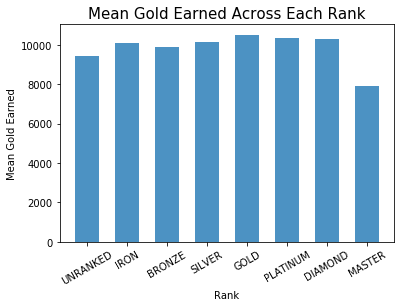

In [214]:
plt.bar(list(gold_dict.keys()), list(gold_dict.values()), alpha=0.8, width=0.6)
plt.xlabel('Rank', fontsize=10)
plt.ylabel('Mean Gold Earned', fontsize=10)
plt.title('Mean Gold Earned Across Each Rank', fontsize=15)
plt.xticks(rank_order, fontsize=10, rotation=30)
plt.show()

# Conclusions

<mark>:o</mark>